In [1]:
import wrds
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt

Establishing connection with WRDS 

In [2]:
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


## Part 1 

### Step 1: Collecting User Inputs - tickers, in-sample and out-of-sample periods, min coverage ratio

In [3]:
def get_user_inputs():
    print("=== Portfolio Project: Part 1 (Data Acquisition & Coverage Validation) ===")
    tickers = input("Enter tickers separated by commas (e.g., AAPL,MSFT,GOOGL): ").upper().replace(" ", "").split(",")
    is_start = input("Enter In-Sample start date (YYYY-MM): ")
    is_end   = input("Enter In-Sample end date   (YYYY-MM): ")
    oos_start = input("Enter Out-of-Sample start date (YYYY-MM): ")
    oos_end   = input("Enter Out-of-Sample end date   (YYYY-MM): ")
    min_coverage_str = input("Min coverage ratio per period (default 0.95): ").strip() or "0.95"

    return {
        "tickers": [t for t in tickers if t],
        "is_start": pd.to_datetime(is_start + "-01"),
        "is_end": pd.to_datetime(is_end + "-01") + relativedelta(day=31),     # month-end
        "oos_start": pd.to_datetime(oos_start + "-01"),
        "oos_end": pd.to_datetime(oos_end + "-01") + relativedelta(day=31),   # month-end
        "min_coverage": float(min_coverage_str),
    }


### Step 2: Fetch CRSP monthly returns by tickers
   - Uses msenames for ticker/exchcd/shrcd + validity window
   - Joins msf (RET) with msedelist (DLRET)
   - Filters to exchcd in (1,2,3) and shrcd in (10,11)
   - Combines RET with DLRET => (1+RET)*(1+DLRET)-1

In [4]:
import pandas as pd
import numpy as np

def fetch_crsp_monthly_returns(db, tickers, start_date, end_date):
    """
    Fetch monthly returns for given tickers from CRSP, including delisting adjustments.

    Parameters:
        db          : Database connection object with `raw_sql` method
        tickers     : List of ticker strings
        start_date  : datetime or string 'YYYY-MM-DD'
        end_date    : datetime or string 'YYYY-MM-DD'
    
    Returns:
        pandas DataFrame: index = date, columns = tickers, values = total monthly returns
    """
    
    # --- Prepare tickers for SQL ---
    tickers_sql = "', '".join([t.replace("'", "''") for t in tickers])

    # --- Pull monthly returns ---
    sql_msf = f"""
        SELECT
            msf.permno,
            msf.date,
            msf.ret,
            n.ticker,
            COALESCE(n.nameendt, DATE '2099-12-31') AS nameenddt
        FROM crsp.msf AS msf
        JOIN crsp.msenames AS n
          ON msf.permno = n.permno
         AND msf.date >= n.namedt
         AND msf.date <= COALESCE(n.nameendt, msf.date)
        WHERE n.ticker IN ('{tickers_sql}')
          AND msf.date BETWEEN '{start_date:%Y-%m-%d}' AND '{end_date:%Y-%m-%d}'
          AND n.shrcd IN (10, 11)
          AND n.exchcd IN (1, 2, 3)
    """
    msf = db.raw_sql(sql_msf, date_cols=['date', 'nameenddt'])
    if msf.empty:
        raise ValueError("No CRSP monthly returns found for the provided tickers and dates.")

    # --- Pull delisting returns ---
    sql_dl = f"""
        SELECT permno, dlret, dlstdt
        FROM crsp.msedelist
        WHERE dlstdt BETWEEN '{start_date:%Y-%m-%d}' AND '{end_date:%Y-%m-%d}';
    """
    dl = db.raw_sql(sql_dl, date_cols=['dlstdt'])

    # --- Merge delisting returns ---
    msf = msf.merge(dl, left_on=['permno', 'date'], right_on=['permno', 'dlstdt'], how='left')

    # --- Compute final return (adjusted for delisting) ---
    msf['ret'] = pd.to_numeric(msf['ret'], errors='coerce').fillna(0)
    msf['dlret'] = pd.to_numeric(msf['dlret'], errors='coerce').fillna(0)
    msf['ret_final'] = (1 + msf['ret']) * (1 + msf['dlret']) - 1

    # --- Pivot to wide format: date x ticker ---
    wide = msf.pivot_table(index='date', columns='ticker', values='ret_final', aggfunc='first')
    wide = wide.reindex(columns=tickers)  # Ensure all requested tickers, in order
    wide.index.name = 'date'

    return wide



### Step 3: Coverage validation & window consistency

In [5]:

def validate_and_align(returns_wide, is_start, is_end, oos_start, oos_end, min_coverage):
    # Slice by month-end windows
    is_df = returns_wide.loc[(returns_wide.index >= is_start) & (returns_wide.index <= is_end)].copy()
    oos_df = returns_wide.loc[(returns_wide.index >= oos_start) & (returns_wide.index <= oos_end)].copy()

    def count_months(start, end):
        return (end.year - start.year) * 12 + (end.month - start.month) + 1

    exp_is = count_months(is_start, is_end)
    exp_oos = count_months(oos_start, oos_end)

    # Coverage ratios per ticker in each window
    is_cov = is_df.notna().sum(axis=0) / max(exp_is, 1)
    oos_cov = oos_df.notna().sum(axis=0) / max(exp_oos, 1)

    # Keep tickers meeting min coverage in BOTH windows
    keep_mask = (is_cov >= min_coverage) & (oos_cov >= min_coverage)
    kept = list(is_cov.index[keep_mask])
    dropped = list(is_cov.index[~keep_mask])

    is_df = is_df[kept]
    oos_df = oos_df[kept]

    # Drop months with any remaining missing values to make fully observed panels
    is_clean = is_df.dropna(axis=0, how='any')
    oos_clean = oos_df.dropna(axis=0, how='any')

    summary = {
        "expected_months_is": exp_is,
        "expected_months_oos": exp_oos,
        "coverage_is": is_cov.round(3).to_dict(),
        "coverage_oos": oos_cov.round(3).to_dict(),
        "kept_tickers": kept,
        "dropped_tickers": dropped,
        "final_is_shape": is_clean.shape,
        "final_oos_shape": oos_clean.shape
    }
    return is_clean, oos_clean, summary

### Step 4: Execute Part 1 

In [7]:
def run_part1(db):
    params = get_user_inputs()
    print("\nCollecting monthly CRSP returns…")
    returns_wide = fetch_crsp_monthly_returns(
        db=db,
        tickers=params["tickers"],
        start_date=min(params["is_start"], params["oos_start"]),
        end_date=max(params["is_end"], params["oos_end"]),
    )
    is_df, oos_df, summary = validate_and_align(
        returns_wide,
        params["is_start"], params["is_end"],
        params["oos_start"], params["oos_end"],
        params["min_coverage"]
    )
    print("\n=== Coverage Summary ===")
    print(f"Requested tickers : {params['tickers']}")
    print(f"Kept tickers      : {summary['kept_tickers']}")
    print(f"Dropped tickers   : {summary['dropped_tickers']}")
    print(f"IS expected months: {summary['expected_months_is']}, final matrix shape: {summary['final_is_shape']}")
    print(f"OOS expected months: {summary['expected_months_oos']}, final matrix shape: {summary['final_oos_shape']}")
    return is_df, oos_df, summary

is_data, oos_data, info = run_part1(db)


=== Portfolio Project: Part 1 (Data Acquisition & Coverage Validation) ===


=== Coverage Summary ===
Requested tickers : ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
Kept tickers      : ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
Dropped tickers   : []
IS expected months: 24, final matrix shape: (24, 4)
OOS expected months: 12, final matrix shape: (12, 4)


In [8]:
is_data.head()

ticker,AAPL,MSFT,GOOGL,AMZN
date,,,,
2018-01-31,-0.010636,0.110708,0.12229,0.240639
2018-02-28,0.06761,-0.008631,-0.066231,0.042429
2018-03-29,-0.058051,-0.026661,-0.060494,-0.043049
2018-04-30,-0.01502,0.024652,-0.017895,0.082075
2018-05-31,0.135181,0.061377,0.079935,0.040539


In [9]:
oos_data.head()

ticker,AAPL,MSFT,GOOGL,AMZN
date,,,,
2020-01-31,0.05401,0.079455,0.069726,0.087064
2020-02-28,-0.11431,-0.045292,-0.065279,-0.062214
2020-03-31,-0.069762,-0.026542,-0.132388,0.035021
2020-04-30,0.155374,0.136326,0.159,0.2689
2020-05-29,0.084956,0.025389,0.064469,-0.012785


In [10]:
info

{'expected_months_is': 24,
 'expected_months_oos': 12,
 'coverage_is': {'AAPL': 1.0, 'MSFT': 1.0, 'GOOGL': 1.0, 'AMZN': 1.0},
 'coverage_oos': {'AAPL': 1.0, 'MSFT': 1.0, 'GOOGL': 1.0, 'AMZN': 1.0},
 'kept_tickers': ['AAPL', 'MSFT', 'GOOGL', 'AMZN'],
 'dropped_tickers': [],
 'final_is_shape': (24, 4),
 'final_oos_shape': (12, 4)}

## Part 2

### Step 1: Prompt Initial Weights 

In [11]:
import numpy as np

def prompt_initial_weights(tickers):
    """
    Prompt user for initial portfolio weights.
    
    Options:
      - Equal weights across all tickers
      - Custom weights (comma-separated)
    
    Returns:
        numpy array of weights, normalized to sum 1
    """
    print("\n=== Initial Weights ===")
    print(f"Tickers: {tickers}")
    use_equal = input("Use equal weights? (y/n, default y): ").strip().lower() or "y"
    if use_equal == 'y':
        w0 = np.repeat(1 / len(tickers), len(tickers))
        print(f"Using equal weights: {w0}")
        return w0

    # Ask for custom weights
    raw = input(f"Enter {len(tickers)} weights separated by commas: ").strip()
    vals = [float(x) for x in raw.split(",")]
    if len(vals) != len(tickers):
        print(f"Expected {len(tickers)} weights, got {len(vals)}.")

    # Normalize weights to sum 1
    w0 = np.array(vals, dtype=float)
    w0 = w0 / w0.sum()
    
    print(f"Using custom weights (normalized): {w0}")
    return w0


### Step 2: Compile data for Optimization

In [12]:
def run_part2(is_df, oos_df, summary):
    """
    Builds the initial dataset for optimization:
      - Confirms fully observed IS/OOS matrices (or applies optional stricter cleaning)
      - Prompts for initial portfolio weights aligned to kept tickers
    Returns:
      is2, oos2, w0, meta
    """

    print("\n=== Part 2: Build Initial Dataset ===")

    is2, oos2 = is_df.copy(), oos_df.copy()

    # Prompt for initial weights aligned to final ticker order
    w0 = prompt_initial_weights(list(is2.columns))

    meta = {
        "tickers_final": list(is2.columns),
        "n_assets": is2.shape[1],
        "n_months_is": is2.shape[0],
        "n_months_oos": oos2.shape[0],
    }
    print("Initial dataset ready for Part 3+ (mean/cov + optimization).")
    return is2, oos2, w0, meta


is2, oos2, w0, meta = run_part2(is_data, oos_data, info)


=== Part 2: Build Initial Dataset ===

=== Initial Weights ===
Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
Using equal weights: [0.25 0.25 0.25 0.25]
Initial dataset ready for Part 3+ (mean/cov + optimization).


In [13]:
is2.head()

ticker,AAPL,MSFT,GOOGL,AMZN
date,,,,
2018-01-31,-0.010636,0.110708,0.12229,0.240639
2018-02-28,0.06761,-0.008631,-0.066231,0.042429
2018-03-29,-0.058051,-0.026661,-0.060494,-0.043049
2018-04-30,-0.01502,0.024652,-0.017895,0.082075
2018-05-31,0.135181,0.061377,0.079935,0.040539


In [14]:
oos2.head()

ticker,AAPL,MSFT,GOOGL,AMZN
date,,,,
2020-01-31,0.05401,0.079455,0.069726,0.087064
2020-02-28,-0.11431,-0.045292,-0.065279,-0.062214
2020-03-31,-0.069762,-0.026542,-0.132388,0.035021
2020-04-30,0.155374,0.136326,0.159,0.2689
2020-05-29,0.084956,0.025389,0.064469,-0.012785


In [15]:
w0

array([0.25, 0.25, 0.25, 0.25])

In [16]:
meta

{'tickers_final': ['AAPL', 'MSFT', 'GOOGL', 'AMZN'],
 'n_assets': 4,
 'n_months_is': 24,
 'n_months_oos': 12}

## Part 3

### Initial Calculations

In [17]:
def run_part3(is2: pd.DataFrame):
    """
    Computes in-sample statistics:
      - Mean returns vector (mu)          [shape: (N,)]
      - Sample covariance matrix (Sigma)  [shape: (N, N)]
      - Inverse covariance (Sigma_inv)    [shape: (N, N)]

    Returns:
      mu, Sigma, Sigma_inv, stats_meta
    """
    # --- Mean vector (monthly) ---
    mu = is2.mean(axis=0).values

    # --- Sample covariance matrix (monthly) ---
    Sigma = is2.cov().values

    # --- Inverse covariance matrix ---
    Sigma_inv = np.linalg.inv(Sigma)

    stats_meta = {
        "n_assets": is2.shape[1],
        "n_months_is": is2.shape[0],
        "columns_order": list(is2.columns),
    }

    # Console summary
    print(f"Assets: {stats_meta['n_assets']}, IS months: {stats_meta['n_months_is']}")
    print("First 5 mean returns:", np.round(mu[:5], 6))
    print("Covariance matrix shape:", Sigma.shape)
    print("Inverse covariance shape:", Sigma_inv.shape)

    return mu, Sigma, Sigma_inv, stats_meta

mu, Sigma, Sigma_inv, stats_meta = run_part3(is2)


Assets: 4, IS months: 24
First 5 mean returns: <FloatingArray>
[0.028388, 0.028355, 0.011757, 0.023134]
Length: 4, dtype: Float64
Covariance matrix shape: (4, 4)
Inverse covariance shape: (4, 4)


In [18]:
mu

<FloatingArray>
[0.028387666666666672,  0.02835512499999999, 0.011756708333333338,
 0.023134499999999985]
Length: 4, dtype: Float64

In [19]:
Sigma

array([[0.00803499, 0.00235318, 0.00206921, 0.00300109],
       [0.00235318, 0.00254968, 0.00197779, 0.0033785 ],
       [0.00206921, 0.00197779, 0.00359196, 0.00343477],
       [0.00300109, 0.0033785 , 0.00343477, 0.00814495]])

In [20]:
Sigma_inv

array([[ 171.80222864, -153.93070681,  -24.69509839,   10.96171718],
       [-153.93070681, 1132.3613048 , -234.4568262 , -314.1106503 ],
       [ -24.69509839, -234.4568262 ,  536.27928529, -119.80069157],
       [  10.96171718, -314.1106503 , -119.80069157,  299.54905951]])

In [21]:
stats_meta

{'n_assets': 4,
 'n_months_is': 24,
 'columns_order': ['AAPL', 'MSFT', 'GOOGL', 'AMZN']}

## Part 4: Portfolio Optimization 

### Step 1: Portfolio Stats

In [23]:
def portfolio_stats(w, mu, Sigma, rf=0.04):
    """
    Compute monthly portfolio performance.
    
    Returns:
        ret    : expected portfolio return
        vol    : portfolio volatility
        sharpe : Sharpe ratio
    """
    w = np.array(w).ravel()
    mu = np.array(mu).ravel()
    Sigma = np.array(Sigma)
    
    ret = float(w @ mu)
    vol = float(np.sqrt(w @ Sigma @ w))
    sharpe = (ret - rf) / vol if vol > 0 else np.nan
    
    return ret, vol, sharpe

# Example usage:
rf_annual = float(input("Enter ANNUAL risk-free rate (default 0.04): ") or 0.04)
rf_monthly = rf_annual/12
r_orig, v_orig, s_orig = portfolio_stats(w0, mu, Sigma, rf_monthly)
print(f"Expected return: {r_orig:.4f}, Volatility: {v_orig:.4f}, Sharpe: {s_orig:.4f}")


Expected return: 0.0229, Volatility: 0.0585, Sharpe: 0.3346


In [24]:
#Expected return, volatility, Sharpe ratio (monthly)
print(r_orig, v_orig, s_orig)

0.0229085 0.05849714233558208 0.33463458017093034


### Step 2: Global Minimum Variance Optimization

In [25]:
def gmv(Sigma_inv, n):
    """Global Minimum Variance portfolio weights (closed form)."""
    one = np.ones(n)
    w = Sigma_inv @ one
    return w / (one @ Sigma_inv @ one)

In [26]:
n = mu.shape[0]
w_gmv = gmv(Sigma_inv, n)
r_gmv, v_gmv, s_gmv = portfolio_stats(w_gmv, mu, Sigma, rf_monthly)

In [27]:
w_gmv

array([ 0.00884355,  0.91865352,  0.33622028, -0.26371735])

In [28]:
print(r_gmv, v_gmv, s_gmv)  

0.024151457909468186 0.04622860384767681 0.45032994387480413


### Step 3: Efficient Portfolio Optimization

In [29]:
import numpy as np

def ep(mu, Sigma, w0=None, target_return=None):
    """
    Closed-form Markowitz optimization using KKT system.
    
    Args:
        mu (np.array): Expected returns vector (N,)
        Sigma (np.array): Covariance matrix (N,N)
        target_return (float or None): Target return constraint. 
                                       If None -> Global Minimum Variance portfolio.
    
    Returns:
        w (np.array): Optimal portfolio weights (N,)
    """
    mu = np.array(mu).ravel()
    Sigma = np.array(Sigma)
    n = len(mu)
    ones = np.ones(n)

    # If target_return not specified, compute from w0
    if target_return is None:
        if w0 is None:
            raise ValueError("If target_return=None, you must provide w0.")
        target_return = float(np.dot(w0, mu))

    # Build block matrix A
    top = np.hstack([2*Sigma, mu.reshape(-1,1), ones.reshape(-1,1)])
    mid = np.hstack([mu.reshape(1,-1), np.array([[0,0]])])
    bot = np.hstack([ones.reshape(1,-1), np.array([[0,0]])])
    A = np.vstack([top, mid, bot])

    
    # Build RHS vector b
    b = np.concatenate([np.zeros(n), [target_return], [1]])

    #print(A)
    #print(b)

    # Solve system
    sol=np.linalg.inv(A) @ b
    w = sol[:n]  # portfolio weights
    return w


In [30]:
mu_np = np.asarray(mu, dtype=float)
target = float(w0 @ mu_np)
w_ep = ep(mu_np, Sigma, w0, target)
r_ep, v_ep, s_ep = portfolio_stats(w_ep, mu_np, Sigma, rf_monthly)

In [31]:
w_ep

array([ 0.00516421,  0.8468268 ,  0.41080851, -0.26279952])

In [32]:
print(r_ep, v_ep, s_ep)

0.0229085 0.04636008867700669 0.4222417865299598


### Step 4: Optimal Risky Portfolio Optimization

In [33]:
from scipy.optimize import minimize
import numpy as np

def orp_slsqp(mu, Sigma, rf, w0, lower=-1.0, upper=1.0):
    """
    Max Sharpe portfolio using SLSQP optimization.
    mu: mean returns vector
    Sigma: covariance matrix
    rf: risk-free rate (monthly)
    w0: initial guess for weights
    lower, upper: bounds for each weight
    """
    n = len(mu)
    lower = float(input('Enter lower bound constraint: '))
    upper = float(input('Enter upper bound constraint: '))
    if lower>upper:
        raise ValueError('LowerBound cannot exceed Upper bound')
    bounds = [(lower, upper)] * n
    initial_guess = np.array(w0)

    def objective(w):
        ret = w @ mu
        vol = np.sqrt(w @ Sigma @ w)
        return - (ret - rf) / vol

    result = minimize(objective, w0, method='SLSQP',
                   bounds=bounds, constraints=({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}))

    if result.success:
        return result.x.reshape(-1,1)
    else:
        raise RuntimeError("Optimization failed: " + result.message)


In [34]:
mu_np = np.asarray(mu, dtype=float)
w_orp = orp_slsqp(mu_np, Sigma,rf_monthly,w0)
r_orp, v_orp, s_orp = portfolio_stats(w_orp, mu_np, Sigma, rf_monthly)

In [35]:
w_orp = np.array(w_orp).flatten()
w_orp

array([ 0.18441749,  1.        , -0.08725908, -0.09715841])

In [36]:
w_orig=w0.copy()
tickers = list(is2.columns)
sample_results = {
    "weights": pd.DataFrame(
        np.column_stack([w_orig, w_gmv, w_ep, w_orp]),
        index=tickers, columns=["original", "gmv", "ep", "orp"]
    ),
    "metrics": pd.DataFrame(
        {
            "exp_ret_m":   [r_orig, r_gmv, r_ep, r_orp],
            "vol_m":       [v_orig, v_gmv, v_ep, v_orp],
            "sharpe_m_rf": [s_orig, s_gmv, s_ep, s_orp],
        },
        index=["original", "gmv", "ep", "orp"]
    ),
    "rf_monthly": rf_monthly,
}

print("\n--- Sample Σ results (monthly) ---")
print(sample_results["metrics"].round(6))

print("\n--- Weights (monthly) ---")
print(sample_results["weights"].round(6))


--- Sample Σ results (monthly) ---
          exp_ret_m     vol_m  sharpe_m_rf
original   0.022908  0.058497     0.334635
gmv        0.024151  0.046229     0.450330
ep         0.022908  0.046360     0.422242
orp        0.030317  0.051745     0.521468

--- Weights (monthly) ---
       original       gmv        ep       orp
AAPL       0.25  0.008844  0.005164  0.184417
MSFT       0.25  0.918654  0.846827  1.000000
GOOGL      0.25  0.336220  0.410809 -0.087259
AMZN       0.25 -0.263717 -0.262800 -0.097158


### Step 5: Ledoit-Wolf Matrix Shrinkage Optimizations 

In [37]:
import numpy as np

def lw_covariance(X):
    """
    Ledoit-Wolf shrinkage covariance estimator (from scratch).
    X: (T x N) matrix of demeaned returns
    """
    T, N = X.shape
    # Center data
    Xc = X - X.mean(axis=0)

    # Sample covariance
    sample = (Xc.T @ Xc) / (T-1)

    # Target: diagonal with average variance
    mu = np.trace(sample) / N
    F = mu * np.eye(N)

    # d² = || sample - F ||²_Fro
    diff = sample - F
    d2 = np.sum(diff**2)

    # --- Beta calculation (time-iterated) ---
    b2_num = 0.0
    for t in range(T):
        x_t = Xc[t, :][:, None]   # column vector (N x 1)
        outer = x_t @ x_t.T       # (N x N)
        b2_num += np.sum((outer - sample) ** 2)

    b2 = b2_num / (T**2)

    # Shrinkage intensity
    delta = max(0, min(1, b2 / d2))

    # Final shrinked covariance
    Sigma_lw = delta * F + (1 - delta) * sample

    # print(d2, b2, delta)
    # print(Sigma_lw)
    return Sigma_lw



In [38]:
X = is2.to_numpy(dtype=float, copy=False)

# get Ledoit-Wolf covariance from scratch
Sigma_lw= lw_covariance(X)

In [40]:
Sigma_lw_inv = np.linalg.inv(Sigma_lw)
# Weights
w_gmv_lw = gmv(Sigma_lw_inv, n)
mu_np = np.asarray(mu, dtype=float)
w_mve_lw = ep(mu_np, Sigma_lw, w0)
w_orp_lw = orp_slsqp(mu_np, Sigma_lw, rf_monthly, w0,
                              lower=-1.0, upper=1.0)
w_orp_lw = np.array(w_orp_lw).flatten()

tickers = list(is2.columns)
r_ep_lw, v_ep_lw, s_ep_lw = portfolio_stats(w_mve_lw, mu_np, Sigma_lw, rf_monthly)
r_gmv_lw, v_gmv_lw, s_gmv_lw = portfolio_stats(w_gmv_lw, mu_np, Sigma_lw, rf_monthly)
r_orp_lw, v_orp_lw, s_orp_lw = portfolio_stats(w_orp_lw, mu_np, Sigma_lw, rf_monthly)
r_orig_lw, v_orig_lw, s_orig_lw = portfolio_stats(w0, mu_np, Sigma_lw, rf_monthly)
lw_results = {
    "weights": pd.DataFrame(
        np.column_stack([np.asarray(w0), np.asarray(w_gmv_lw), np.asarray(w_mve_lw), np.asarray(w_orp_lw)]),
        index=list(tickers),
        columns=["original", "gmv_lw", "ep_lw", "orp_lw"]
    )
}

In [41]:
print("\n--- Ledoit–Wolf weights ---")
print(lw_results["weights"].round(6))


--- Ledoit–Wolf weights ---
       original    gmv_lw     ep_lw    orp_lw
AAPL       0.25  0.132338  0.140030  0.247364
MSFT       0.25  0.516373  0.542929  0.912260
GOOGL      0.25  0.370062  0.333635 -0.173720
AMZN       0.25 -0.018773 -0.016595  0.014096


### Step 6: Run whole part 4 

In [42]:
def run_part4(is2, mu, Sigma, Sigma_inv, w0):
    """Run portfolio optimization using closed-form formulas only."""
    mu = np.asarray(mu, dtype=float).ravel()
    Sigma = np.asarray(Sigma, dtype=float)
    Sigma_inv = np.asarray(Sigma_inv, dtype=float)
    w0 = np.asarray(w0, dtype=float).ravel()
    n = is2.shape[1]
    tickers = list(is2.columns)

    print("\n=== Part 4: Portfolio Optimization (Simplified) ===")
    rf_annual_str = input("Enter ANNUAL risk-free rate (default 0.04): ").strip() or "0.04"
    rf_annual = float(rf_annual_str)
    rf_monthly = rf_annual/12

    # ====== Using sample Σ ======
    w_orig = w0.copy()
    r_o, v_o, s_o = portfolio_stats(w_orig, mu, Sigma, rf_monthly)

    w_gmv = gmv(Sigma_inv, n)
    r_gmv, v_gmv, s_gmv = portfolio_stats(w_gmv, mu, Sigma, rf_monthly)

    target = float(w_orig @ mu)
    w_mve = ep(mu, Sigma, w0)
    r_mve, v_mve, s_mve = portfolio_stats(w_mve, mu, Sigma, rf_monthly)

    w_orp = orp_slsqp(mu, Sigma, rf_monthly, w0,
                               lower=-1.0, upper=1.0)
    r_orp, v_orp, s_orp = portfolio_stats(w_orp, mu, Sigma, rf_monthly)

    sample_results = {
        "weights": pd.DataFrame(
            np.column_stack([w_orig, w_gmv, w_mve, w_orp]),
            index=tickers, columns=["original", "gmv", "ep", "orp"]
        ),
        "metrics": pd.DataFrame(
            {
                "exp_ret_m":   [r_o, r_gmv, r_mve, r_orp],
                "vol_m":       [v_o, v_gmv, v_mve, v_orp],
                "sharpe_m_rf": [s_o, s_gmv, s_mve, s_orp],
            },
            index=["original", "gmv", "ep", "orp"]
        ),
        "rf_monthly": rf_monthly,
    }

    # ====== Ledoit–Wolf Σ̂ ======

    print('Ledoit Wolf Calculations:')
    X = is2.to_numpy(dtype=float, copy=False)

    # get Ledoit-Wolf covariance from scratch
    Sigma_lw= lw_covariance(X)
    Sigma_lw_inv = np.linalg.inv(Sigma_lw)

    w_gmv_lw = gmv(Sigma_lw_inv, n)
    w_mve_lw = ep(mu, Sigma_lw, w0)
    w_orp_lw = orp_slsqp(mu, Sigma_lw, rf_monthly, w0,
                                  lower=-1.0, upper=1.0)

    lw_results = {
        "weights": pd.DataFrame(
            np.column_stack([w_orig, w_gmv_lw, w_mve_lw, w_orp_lw]),
            index=tickers, columns=["original", "gmv_lw", "ep_lw", "orp_lw"]
        )
    }

    print("\n--- Sample Σ results (monthly) ---")
    print(sample_results["metrics"].round(6))
    print("\n--- Sample Σ weights ---")
    print(sample_results["weights"].round(6))
    print("\n--- Ledoit–Wolf Σ̂ weights ---")
    print(lw_results["weights"].round(6))

    return {"sample": sample_results, "lw": lw_results,
            "Sigma_lw": Sigma_lw, "Sigma_lw_inv": Sigma_lw_inv}

In [43]:
opt = run_part4(is2, mu, Sigma, Sigma_inv, w0)


=== Part 4: Portfolio Optimization (Simplified) ===
Ledoit Wolf Calculations:

--- Sample Σ results (monthly) ---
          exp_ret_m     vol_m  sharpe_m_rf
original   0.022908  0.058497     0.334635
gmv        0.024151  0.046229     0.450330
ep         0.022908  0.046360     0.422242
orp        0.030317  0.051745     0.521468

--- Sample Σ weights ---
       original       gmv        ep       orp
AAPL       0.25  0.008844  0.005164  0.184417
MSFT       0.25  0.918654  0.846827  1.000000
GOOGL      0.25  0.336220  0.410809 -0.087259
AMZN       0.25 -0.263717 -0.262800 -0.097158

--- Ledoit–Wolf Σ̂ weights ---
       original    gmv_lw     ep_lw    orp_lw
AAPL       0.25  0.132338  0.140030  0.247364
MSFT       0.25  0.516373  0.542929  0.912260
GOOGL      0.25  0.370062  0.333635 -0.173720
AMZN       0.25 -0.018773 -0.016595  0.014096


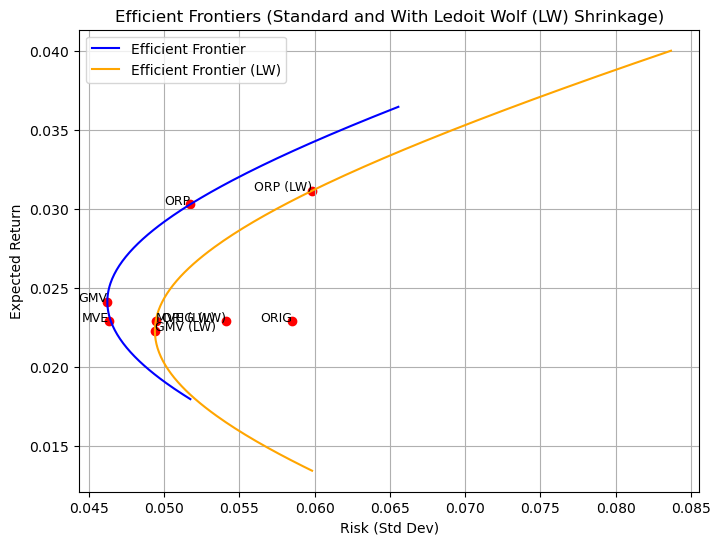

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def efficient_frontier_two_funds(weights1, weights2, mu, Sigma, n_points=200):
    """
    Generate an efficient frontier given two frontier portfolios.
    
    Parameters:
    -----------
    weights1, weights2 : np.array
        Weight vectors for the two portfolios (same length as number of assets).
    mu : np.array
        Expected returns for each asset (1D array).
    Sigma : np.array
        Covariance matrix of asset returns.
    n_points : int
        Number of points to sample along the frontier.
        
    Returns:
    --------
    risks, returns : lists
        Risk-return coordinates of the frontier segment.
    """
    weights = np.linspace(-1,2, n_points)
    risks, rets = [], []
    
    for w in weights:
        combo = w * weights1 + (1 - w) * weights2
        ret = combo @ mu
        risk = np.sqrt(combo @ Sigma @ combo)
        
        rets.append(ret)
        risks.append(risk)
    
    return risks, rets

# Compute efficient frontier
w1=w_gmv
w2=w_orp
risks, rets = efficient_frontier_two_funds(w1, w2, mu_np, Sigma)

w3=w_gmv_lw
w4=w_orp_lw
risks_lw, rets_lw = efficient_frontier_two_funds(w3, w4, mu_np, Sigma_lw)

# Plot
plt.figure(figsize=(8,6))
plt.plot(risks, rets, 'b-', label="Efficient Frontier")
plt.scatter(np.sqrt(w1 @ Sigma @ w1),w1 @ mu_np,c='red', marker='o')
plt.text(np.sqrt(w1 @ Sigma @ w1),w1 @ mu_np, "GMV", fontsize=9, ha="right")
plt.scatter(np.sqrt(w2 @ Sigma @ w2),w2 @ mu_np,c='red', marker='o')
plt.text(np.sqrt(w2 @ Sigma @ w2),w2 @ mu_np, "ORP", fontsize=9, ha="right")
plt.scatter(v_orig,r_orig,c='red', marker='o')
plt.text(v_orig,r_orig, "ORIG", fontsize=9, ha="right")
plt.scatter(v_ep,r_ep,c='red', marker='o')
plt.text(v_ep,r_ep, "MVE", fontsize=9, ha="right")
plt.plot(risks_lw, rets_lw, color = 'orange', label="Efficient Frontier (LW)")
plt.scatter(np.sqrt(w3 @ Sigma_lw @ w3),w3 @ mu_np,c='red', marker='o')
plt.text(np.sqrt(w3 @ Sigma_lw @ w3),w3 @ mu_np, "GMV (LW)", fontsize=9, ha="left")
plt.scatter(np.sqrt(w4 @ Sigma_lw @ w4),w4 @ mu_np,c='red', marker='o')
plt.text(np.sqrt(w4 @ Sigma_lw @ w4),w4 @ mu_np, "ORP (LW)", fontsize=9, ha="right")
plt.scatter(v_orig_lw,r_orig_lw,c='red', marker='o')
plt.text(v_orig_lw,r_orig_lw, "ORIG (LW)", fontsize=9, ha="right")
plt.scatter(v_ep_lw,r_ep_lw,c='red', marker='o')
plt.text(v_ep_lw,r_ep_lw, "MVE (LW)", fontsize=9, ha="left")
plt.xlabel("Risk (Std Dev)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontiers (Standard and With Ledoit Wolf (LW) Shrinkage)")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
def extract_inputs_from_opt(opt):
    # Sample block
    sample_wdf = opt["sample"]["weights"]
    sample_metrics = opt["sample"]["metrics"]  # monthly metrics were printed; we recompute full metrics below
    rf_m = opt["sample"]["rf_monthly"]
    # LW block
    lw_wdf = opt["lw"]["weights"]
    Sigma_lw = opt["Sigma_lw"]
    return sample_wdf, lw_wdf, rf_m, Sigma_lw

In [46]:
%pip install XlsxWriter reportlab

Note: you may need to restart the kernel to use updated packages.


In [47]:
%pip install reportlab

Note: you may need to restart the kernel to use updated packages.


## Part 5: Reporting

In [50]:
# =========================
# PART 5: Reporting & Visualization (Final Version)
# =========================
# Prereqs in memory:
#   is2, oos2, w0, meta
#   mu, Sigma, Sigma_inv
#   opt  (from run_part4(...))
#
# Files produced:
#   - 'portfolio_report.xlsx' (returns, metrics, plots embedded)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from pathlib import Path

# ---------- Utility: annualization ----------
def annualize_metrics(exp_ret_m, vol_m, rf_m):
    rf_a = (rf_m)*12
    ret_a = (1 + exp_ret_m)**12 - 1
    vol_a = vol_m * sqrt(12.0)
    sharpe_a = (ret_a - rf_a) / vol_a if vol_a > 0 else np.nan
    return ret_a, vol_a, sharpe_a, rf_a

# ---------- Utility: turn weights + returns into metrics ----------
def portfolio_series(returns_df: pd.DataFrame, w: np.ndarray) -> pd.Series:
    w = np.asarray(w, dtype=float).ravel()
    X = returns_df.to_numpy(dtype=float, copy=False)
    return pd.Series(X @ w, index=returns_df.index, name="port_ret")

def series_to_metrics(port_ret: pd.Series, rf_m: float):
    # Monthly metrics
    exp_ret_m = float(port_ret.mean())
    vol_m = float(port_ret.std(ddof=1)) if len(port_ret) > 1 else np.nan
    sharpe_m = (exp_ret_m - rf_m) / vol_m if vol_m > 0 else np.nan
    # Annualized
    ret_a, vol_a, sharpe_a, rf_a = annualize_metrics(exp_ret_m, vol_m, rf_m)
    return {
        "exp_ret_m": exp_ret_m,
        "vol_m": vol_m,
        "sharpe_m_rf": sharpe_m,
        "exp_ret_a": ret_a,
        "vol_a": vol_a,
        "sharpe_a_rf": sharpe_a,
        "rf_m": rf_m,
        "rf_a": rf_a,
    }

# ---------- Collect weights & rf from Part 4 'opt' ----------
def extract_inputs_from_opt(opt):
    sample_wdf = opt["sample"]["weights"]
    rf_m = opt["sample"]["rf_monthly"]
    lw_wdf = opt["lw"]["weights"]
    Sigma_lw = opt["Sigma_lw"]
    return sample_wdf, lw_wdf, rf_m, Sigma_lw

# ---------- Build IS/OOS metrics tables ----------
def build_metrics_tables(is2, oos2, sample_wdf, lw_wdf, rf_m):
    sample_cols = ["original", "gmv", "ep", "orp"]
    lw_cols = ["original", "gmv_lw", "ep_lw", "orp_lw"]

    def _table_for_panel(ret_df, wdf, cols):
        rows, idx = [], []
        for c in cols:
            w = wdf[c].to_numpy(dtype=float)
            s = portfolio_series(ret_df, w)
            m = series_to_metrics(s, rf_m)
            rows.append(m)
            idx.append(c)
        tbl = pd.DataFrame(rows, index=idx)
        return tbl[
            ["exp_ret_m", "vol_m", "sharpe_m_rf",
             "exp_ret_a", "vol_a", "sharpe_a_rf", "rf_m", "rf_a"]
        ]

    return {
        "IS_sample": _table_for_panel(is2, sample_wdf, sample_cols),
        "OOS_sample": _table_for_panel(oos2, sample_wdf, sample_cols),
        "IS_lw": _table_for_panel(is2, lw_wdf, lw_cols),
        "OOS_lw": _table_for_panel(oos2, lw_wdf, lw_cols),
    }

# ---------- Efficient Frontier (Two-Fund method) ----------
def efficient_frontier_two_funds(weights1, weights2, mu, Sigma, n_points=200):

    out_png="efficient_frontier.png"
    weights = np.linspace(-1, 2, n_points)
    risks, rets = [], []
    for w in weights:
        combo = w * weights1 + (1 - w) * weights2
        ret = combo @ mu
        risk = np.sqrt(combo @ Sigma @ combo)
        risks.append(risk); rets.append(ret)    
    return risks, rets

def plot_frontiers_twofunds(is2, mu, Sigma, Sigma_inv, Sigma_lw, sample_wdf, lw_wdf, out_png="efficient_frontier4.png"):
    mu_np = np.asarray(mu, dtype=float).ravel()

    w1=w_gmv
    w2=w_orp
    risks, rets = efficient_frontier_two_funds(w1, w2, mu_np, Sigma)
    
    w3=w_gmv_lw
    w4=w_orp_lw
    risks_lw, rets_lw = efficient_frontier_two_funds(w3, w4, mu_np, Sigma_lw)

    plt.figure(figsize=(8,6))
    plt.plot(risks, rets, 'b-', label="Efficient Frontier")
    plt.scatter(np.sqrt(w1 @ Sigma @ w1),w1 @ mu_np,c='red', marker='o')
    plt.text(np.sqrt(w1 @ Sigma @ w1),w1 @ mu_np, "GMV", fontsize=9, ha="right")
    plt.scatter(np.sqrt(w2 @ Sigma @ w2),w2 @ mu_np,c='red', marker='o')
    plt.text(np.sqrt(w2 @ Sigma @ w2),w2 @ mu_np, "ORP", fontsize=9, ha="right")
    plt.scatter(v_orig,r_orig,c='red', marker='o')
    plt.text(v_orig,r_orig, "ORIG", fontsize=9, ha="right")
    plt.scatter(v_ep,r_ep,c='red', marker='o')
    plt.text(v_ep,r_ep, "MVE", fontsize=9, ha="right")
    plt.plot(risks_lw, rets_lw, color = 'orange', label="Efficient Frontier (LW)")
    plt.scatter(np.sqrt(w3 @ Sigma_lw @ w3),w3 @ mu_np,c='red', marker='o')
    plt.text(np.sqrt(w3 @ Sigma_lw @ w3),w3 @ mu_np, "GMV (LW)", fontsize=9, ha="left")
    plt.scatter(np.sqrt(w4 @ Sigma_lw @ w4),w4 @ mu_np,c='red', marker='o')
    plt.text(np.sqrt(w4 @ Sigma_lw @ w4),w4 @ mu_np, "ORP (LW)", fontsize=9, ha="right")
    plt.scatter(v_orig_lw,r_orig_lw,c='red', marker='o')
    plt.text(v_orig_lw,r_orig_lw, "ORIG (LW)", fontsize=9, ha="right")
    plt.scatter(v_ep_lw,r_ep_lw,c='red', marker='o')
    plt.text(v_ep_lw,r_ep_lw, "MVE (LW)", fontsize=9, ha="left")
    plt.xlabel("Risk (Std Dev)")
    plt.ylabel("Expected Return")
    plt.title("Efficient Frontiers (Standard and With Ledoit Wolf (LW) Shrinkage)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.show()
    plt.savefig(out_png, dpi=200)
    plt.close()
    
    return out_png

# ---------- Excel writer ----------
def save_to_excel(is2, oos2, metrics_dict, chart_png, out_xlsx="portfolio_report.xlsx"):
    out = Path(out_xlsx)
    with pd.ExcelWriter(out, engine="xlsxwriter") as writer:
        # Raw returns
        is2.to_excel(writer, sheet_name="Returns_IS")
        oos2.to_excel(writer, sheet_name="Returns_OOS")
        # Metrics tables
        metrics_dict["IS_sample"].round(6).to_excel(writer, sheet_name="Metrics_IS_Sample")
        metrics_dict["OOS_sample"].round(6).to_excel(writer, sheet_name="Metrics_OOS_Sample")
        metrics_dict["IS_lw"].round(6).to_excel(writer, sheet_name="Metrics_IS_LW")
        metrics_dict["OOS_lw"].round(6).to_excel(writer, sheet_name="Metrics_OOS_LW")
        # Insert chart
        ws = writer.sheets["Metrics_IS_Sample"]
        ws.insert_image("J2", chart_png, {"x_scale":0.8, "y_scale":0.8})
    print(f"Excel saved to: {out.resolve()}")
    return str(out.resolve())

# ---------- Part 5 runner ----------
def run_part5(is2, oos2, mu, Sigma, Sigma_inv, opt, out_xlsx="portfolio_report4.xlsx", out_png="efficient_frontier4.png"):
    sample_wdf, lw_wdf, rf_m, Sigma_lw = extract_inputs_from_opt(opt)
    metrics = build_metrics_tables(is2, oos2, sample_wdf, lw_wdf, rf_m)
    
    chart_file = plot_frontiers_twofunds(is2, mu, Sigma, Sigma_inv, Sigma_lw, sample_wdf, lw_wdf, out_png=out_png)
    xlsx_path = save_to_excel(is2, oos2, metrics, chart_file, out_xlsx=out_xlsx)

    print("\n=== Part 5 complete ===")
    print("IS Metrics (Sample Σ):"); print(metrics["IS_sample"].round(6))
    print("\nOOS Metrics (Sample Σ):"); print(metrics["OOS_sample"].round(6))
    print("\nIS Metrics (LW Σ̂):"); print(metrics["IS_lw"].round(6))
    print("\nOOS Metrics (LW Σ̂):"); print(metrics["OOS_lw"].round(6))

    return {"metrics": metrics, "excel": xlsx_path, "plot_png": chart_file}


In [51]:
run_part5(is2, oos2, mu_np, Sigma, Sigma_inv, opt)

Excel saved to: /Users/shruthichembu/Documents/Fall/FA/portfolio_report4.xlsx

=== Part 5 complete ===
IS Metrics (Sample Σ):
          exp_ret_m     vol_m  sharpe_m_rf  exp_ret_a     vol_a  sharpe_a_rf  \
original   0.022908  0.058497     0.334635   0.312325  0.202640     1.343886   
gmv        0.024151  0.046229     0.450330   0.331589  0.160141     1.820832   
ep         0.022908  0.046360     0.422242   0.312325  0.160596     1.695715   
orp        0.030317  0.051745     0.521468   0.431031  0.179250     2.181479   

              rf_m  rf_a  
original  0.003333  0.04  
gmv       0.003333  0.04  
ep        0.003333  0.04  
orp       0.003333  0.04  

OOS Metrics (Sample Σ):
          exp_ret_m     vol_m  sharpe_m_rf  exp_ret_a     vol_a  sharpe_a_rf  \
original   0.042040  0.082028     0.471866   0.639119  0.284153     2.108437   
gmv        0.024890  0.065993     0.326646   0.343153  0.228606     1.326092   
ep         0.024391  0.067087     0.313891   0.335336  0.232395     1.270

{'metrics': {'IS_sample':           exp_ret_m     vol_m  sharpe_m_rf  exp_ret_a     vol_a  sharpe_a_rf  \
  original   0.022908  0.058497     0.334635   0.312325  0.202640     1.343886   
  gmv        0.024151  0.046229     0.450330   0.331589  0.160141     1.820832   
  ep         0.022908  0.046360     0.422242   0.312325  0.160596     1.695715   
  orp        0.030317  0.051745     0.521468   0.431031  0.179250     2.181479   
  
                rf_m  rf_a  
  original  0.003333  0.04  
  gmv       0.003333  0.04  
  ep        0.003333  0.04  
  orp       0.003333  0.04  ,
  'OOS_sample':           exp_ret_m     vol_m  sharpe_m_rf  exp_ret_a     vol_a  sharpe_a_rf  \
  original   0.042040  0.082028     0.471866   0.639119  0.284153     2.108437   
  gmv        0.024890  0.065993     0.326646   0.343153  0.228606     1.326092   
  ep         0.024391  0.067087     0.313891   0.335336  0.232395     1.270834   
  orp        0.035156  0.073250     0.434441   0.513805  0.253744     1.867